# "Code & Win Challenge" from msg and get-in-it

This jupyter notebook contains my contribution to the "Code & Win Challenge", that was organized by msg and get-in-it in June and July 2020. The notebook is structured into 4 major parts:

#### 1. The Challenge

#### 2. The Distances from Google Maps API

#### 3. The TSP-solving using Branch-and-Bound

#### 4. The Result


I executed the code entirely, so all cells will show output. You have no need to run the code on your machine.
However, if you want to for example check the execution speed, it is quite simple to execute the notebook.
You can just click on "Kernel" > "Restart & Run All".

However, there are two sections of the code, that I per default plugged out:
1. The code calls the Google Maps Disstance API several times. Doing that too often would lead to a credit card charge. Hence, I did this once, saved the result in a csv-file and load the results again later in the file. Nevertheless, if you want to check for yourself that my Google API calls really worked, you can do so. Set the following variable to True and provide a Google Maps API Key. (As mentioned, the key is linked to my personal credit card, so I can not make it public.)

In [1]:
call_google_maps_api = False

"""  
The key to the google directions API is stored locally on my harddrive.
Because it is linked to an account with my credit card information, I will not make it public in this notebook.
If you want to run the entire code yourself, you would need to insert your own google API key here.
This tutorial explains how to get a key: 
https://developers.google.com/maps/premium/apikey/distance-matrix-apikey
If you do not want to get your own key, you can just use the distance data that I gathered in distances.csv
"""

if call_google_maps_api:
    # INSERT YOUR OWN KEY HERE, IF YOU WANT TO RUN THE GOOGLE API CALLS YOURSELF
    api_key = open("google_api_key.txt", "r").read(39)

2. Later on I visualize the algorithm that I use to solve the challenge as a graph. You need four more imports for a need visualization, which are all unnecessary for the actual algorithm. Hence, I made it optional to run this section. I included a picture of the graph. If you want to check the displaying on your own machine and install the packages via pip, you can set the following variable to True.

In [2]:
draw_branch_and_bound_graph = False

A last preliminary for running the code on your machines are the used python libaries. All imports are listed in the cell below. If you are missing one of those in your environment, you can easily install them via `pip`.
You can even install it within the jupyter-notebook. Just uncomment the following lines for the packages you are missing. Or run `pip install name-of-missing-package` in your terminal.
`pip` itself should be already installed together with a rather up-to-date version of python. If not, you can get pip here: https://pip.pypa.io/en/stable/installing/

In [3]:
#!pip install pandas
#!pip install numpy
#!pip install requests
#!pip install networkx
#!pip install queue
#!pip install time

In [4]:
# Staples of python projects
import pandas as pd
import numpy as np

# Used for calling the Google Distance Matrix API
import requests

# Used for modelling the state space graph during the Branch-and-Bound algorithm
import networkx as nx

# Used for sorting which node should be processed next in the approach of finding
from queue import PriorityQueue

# Used for tracking the execution time of the algorithm
import time

# Two packages only needed for a nice plot, but not essential for the algorithm
if draw_branch_and_bound_graph:
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import pydot
    from networkx.drawing.nx_pydot import graphviz_layout

Now that those preliminaries are out of the way, let's dive in.

-------------------------

## 1. The Challenge

The challenge is to find the shortest path to all 21 locations of the company msg in Germany. This tour should start and end in msg's headquarter in Ismaning. Each other location should be visited only once. A csv-file with the addresses and coordinates of the company locations is provided. It is left open how I determine the distances between the location.

So, this challenge is obviously an instance of the wellknown **Travelling Salesperson Problem**. Even though the problem is known, it is not trivial to solve it. For 21 locations, which are all connected to each other with symmetric distances, the number of possible paths can be calculated like this: 
\\[ \frac{(n-1)!}{2} = \frac{20!}{2} = 1,216,451,004,088,320,000\\]


In [5]:
# Calculating the number of possible paths
np.math.factorial(20) / 2

1.21645100408832e+18

Even if we could calculate the length of 1 million paths in just 1 milisecond, it would take 38 years to check all paths. So clearly, a brute force approach does not work. In fact, this problem is known to be NP-hard, so the time for the solution is non-polynomial in regards of the input size.

To come to a solution in reasonable time, I chose the **Branch-and-Bound Algorithm**. More on that in section 3 of this notebook.

One important aspect is that I am free in the determination of the distances. Hence, I decided to look for the distances related to my favourite mode of transportation: **the bike!**

![Me and my bike](img/Me_and_my_bike.png)

In [6]:
# Load the list of locations, that could be downloaded on the website of the challenge
cities = pd.read_csv("msg_standorte_deutschland.csv")
cities

,Nummer,msg Standort,Straße,Hausnummer,PLZ,Ort,Breitengrad,Längengrad
0,1,Ismaning/München (Hauptsitz),Robert-Bürkle-Straße,1,85737,Ismaning,48.229035,11.686153
1,2,Berlin,Wittestraße,30,13509,Berlin,52.580911,13.293884
2,3,Braunschweig,Mittelweg,7,38106,Braunschweig,52.278748,10.524797
3,4,Bretten,Edisonstraße,2,75015,Bretten,49.032767,8.698372
4,5,Chemnitz,Zwickauer Straße,16a,9122,Chemnitz,50.829383,12.914737
5,6,Düsseldorf,Gladbecker Straße,3,40472,Düsseldorf,51.274774,6.794912
6,7,Essen,Am Thyssenhaus,1.3,45128,Essen,51.450577,7.008871
7,8,Frankfurt,Mergenthalerallee,73-75,65760,Eschborn,50.136479,8.570963
8,9,Görlitz,Melanchthonstraße,19,2826,Görlitz,51.145511,14.970028
9,10,Hamburg,Dammtorwall,7a,20354,Hamburg,53.557577,9.986065


-------------------------

## 2. The Distances from Google Maps API

For measuring the distances I use the real road distances, provided by the Google Maps API.

In [7]:
# Setting up a dataframe for the distance matrix
all_cities = cities["msg Standort"].values
number_of_cities = len(all_cities)
zero_matrix = np.zeros((number_of_cities,number_of_cities), dtype = int)
distance_matrix = pd.DataFrame(data = zero_matrix, index = all_cities, columns = all_cities)
duration_matrix = distance_matrix.copy()
distance_matrix

,Ismaning/München (Hauptsitz),Berlin,Braunschweig,Bretten,Chemnitz,Düsseldorf,Essen,Frankfurt,Görlitz,Hamburg,...,Ingolstadt,Köln/Hürth,Lingen (Ems),Münster,Nürnberg,Passau,Schortens/Wilhelmshaven,St. Georgen,Stuttgart,Walldorf
Ismaning/München (Hauptsitz),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Berlin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Braunschweig,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bretten,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chemnitz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Düsseldorf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Essen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Frankfurt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Görlitz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hamburg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Build a function that gets a name of a msg company location and returns the coordinates as a string in the needed format
def get_city_coordinates(cityname):
    # Get the line from the imported csv file
    row = cities[cities["msg Standort"] == cityname]
    
    # The degrees need to be rounded to 6 decimal digits.
    coordinates = str(np.round(row["Breitengrad"].values[0], 6)) + "," + str(np.round(row["Längengrad"].values[0], 6))
    return coordinates

# Quick check if the output looks alright
get_city_coordinates("Ismaning/München (Hauptsitz)")

'48.229035,11.686153'

In [9]:
# Set up a dict with all msg location and there coordinates in the specified format
coordinate_dict = dict()
for location in all_cities:
    coordinate_dict[location] = get_city_coordinates(location)
coordinate_dict

{'Ismaning/München (Hauptsitz)': '48.229035,11.686153',
 'Berlin': '52.580911,13.293884',
 'Braunschweig': '52.278748,10.524797',
 'Bretten': '49.032767,8.698372',
 'Chemnitz': '50.829383,12.914737',
 'Düsseldorf': '51.274774,6.794912',
 'Essen': '51.450577,7.008871',
 'Frankfurt': '50.136479,8.570963',
 'Görlitz': '51.145511,14.970028',
 'Hamburg': '53.557577,9.986065',
 'Hannover': '52.337987,9.769706',
 'Ingolstadt': '48.784417,11.399106',
 'Köln/Hürth': '50.886726,6.913119',
 'Lingen (Ems)': '52.519154,7.322185',
 'Münster': '51.969304,7.61428',
 'Nürnberg': '49.429596,11.017404',
 'Passau': '48.571989,13.453256',
 'Schortens/Wilhelmshaven': '53.537779,7.936809',
 'St. Georgen': '48.126258,8.325873',
 'Stuttgart': '48.694648,9.161239',
 'Walldorf': '49.295011,8.649036'}

In [10]:
# Check if the Google API should be called. If not, api_key would not be defined
if call_google_maps_api:
    
    # Parameters to specify the distance measuring from Google Maps.
    # Most important here is to set the mode to bicycling, otherwise Google will check for highways as well.
    parameters = { 
                    "mode": "bicycling",
                    "traffic_model": "best_guess",
                    "departure_time": "now",
                    "key": api_key    
                }

In [11]:
# Defining a function that for one origin and a list of destinations retrieves the distances using the given parameters
def get_bike_distance(origin, destination_list, parameters):
    # The base url are the fixed part of the API call.
    # The documentation can be found here:
    # https://developers.google.com/maps/documentation/distance-matrix/intro
    base_url = ["https://maps.googleapis.com/maps/api/distancematrix/json?origins=",
                "&destinations=",
                "&mode=",
                "&traffic_model=",
                "&departure_time=",
                "&key="]
    
    # Getting the needed coordinates out of the dict
    origin_coordinates = coordinate_dict[origin]
    destination_coordinates_list = [coordinate_dict[destination] for destination in destination_list]
    destination_coordinates = "|".join(destination_coordinates_list)
    
    # Composing the fixed and the variable parts of the url
    composed_url = base_url[0] + origin_coordinates + base_url[1] + destination_coordinates + base_url[2] + parameters["mode"] + base_url[3] + parameters["traffic_model"] + base_url[4] + parameters["departure_time"] + base_url[5] + parameters["key"]
    
    # Making the actual request and parsing the result as a json
    gmaps_response = requests.get(composed_url).json()
    
    return gmaps_response

So, lets make a test call. From Munich to Berlin or to Hamburg.

In [12]:
if call_google_maps_api:
    api_response = get_bike_distance("Ismaning/München (Hauptsitz)", ["Berlin", "Hamburg"], parameters)
    print(api_response)

{'destination_addresses': ['Wittestraße 30, 13509 Berlin, Germany', 'Dammtorwall 7A, 20354 Hamburg, Germany'], 'origin_addresses': ['Robert-Bürkle-Straße 1, 85737 Ismaning, Germany'], 'rows': [{'elements': [{'distance': {'text': '623 km', 'value': 622638}, 'duration': {'text': '1 day 9 hours', 'value': 119656}, 'status': 'OK'}, {'distance': {'text': '742 km', 'value': 742394}, 'duration': {'text': '1 day 15 hours', 'value': 140069}, 'status': 'OK'}]}], 'status': 'OK'}


The result of the Google Distance API call is a json. 

In [13]:
if call_google_maps_api:
    # Navigating within the nested json to get to the distance in km and the duration in seconds
    km_between_cities = np.round((api_response['rows'][0]['elements'][0]['distance']['value']/1000), decimals=1)
    seconds_between_cities = api_response['rows'][0]['elements'][0]['duration']['value']

    print(f"The distance between the locations in Munich and Berlin is {km_between_cities} km.\n\
    It takes {seconds_between_cities} seconds to cycle so far.")

The distance between the locations in Munich and Berlin is 622.6 km.
    It takes 119656 seconds to cycle so far.


In [14]:
# In this cell the actual api calls to get all the distances are performed
if call_google_maps_api:
    
    # Get the list of all msg locations and initialize a list of cities, which are already called by the API as origin
    all_cities = cities["msg Standort"].values
    called_cities = []

    for current_city in all_cities:
        # Mark the current city as called by the API
        called_cities.append(current_city)

        # Build the list of all cities, for which the distance needs to be retrieved from the API
        list_of_open_cities = [city for city in all_cities if city not in called_cities]

        if len(list_of_open_cities) > 0:
            # Make the api call to get the distance from the current city to all cities, which are uncalled so far
            api_response = get_bike_distance(current_city, list_of_open_cities, parameters)

            # Parse through the json result to write the result in the matrices
            for i in range(len(list_of_open_cities)):
                # Get the destination city
                destination_city = list_of_open_cities[i]

                # Grab the distance (rounded to km) and the duration (in seconds) from the json, that was returned from the API
                km_between_cities = np.round((api_response['rows'][0]['elements'][i]['distance']['value']/1000), decimals=1)
                seconds_between_cities = api_response['rows'][0]['elements'][i]['duration']['value']

                # Write the values in the matrices
                distance_matrix.loc[current_city, destination_city] = km_between_cities
                duration_matrix.loc[current_city, destination_city] = seconds_between_cities
                
    # Show the resulting distance matrix
    display(distance_matrix)

,Ismaning/München (Hauptsitz),Berlin,Braunschweig,Bretten,Chemnitz,Düsseldorf,Essen,Frankfurt,Görlitz,Hamburg,...,Ingolstadt,Köln/Hürth,Lingen (Ems),Münster,Nürnberg,Passau,Schortens/Wilhelmshaven,St. Georgen,Stuttgart,Walldorf
Ismaning/München (Hauptsitz),0,622.6,580.7,287.6,403.0,641.6,673.2,388.0,585.8,742.4,...,77.1,591.4,710.2,651.8,170.2,164.9,794.2,310.5,231.0,309.0
Berlin,0,0.0,238.8,638.2,256.4,579.4,547.7,542.0,237.8,292.8,...,592.3,606.5,472.0,466.6,502.8,605.9,456.1,766.4,664.5,631.7
Braunschweig,0,0.0,0.0,492.8,297.2,341.8,310.1,355.1,394.2,172.8,...,502.4,368.8,263.4,234.4,412.8,656.4,264.7,624.9,530.7,452.2
Bretten,0,0.0,0.0,0.0,457.8,361.0,392.6,168.3,637.6,644.0,...,244.3,310.9,530.0,466.2,215.0,420.4,667.0,140.3,65.1,39.4
Chemnitz,0,0.0,0.0,0.0,0.0,562.2,539.5,411.9,178.5,440.9,...,336.2,544.9,517.6,485.2,271.5,391.4,561.8,578.2,463.1,438.7
Düsseldorf,0,0.0,0.0,0.0,0.0,0.0,35.5,271.3,739.7,390.6,...,579.6,53.0,171.3,118.1,491.8,736.7,308.3,485.0,418.8,322.8
Essen,0,0.0,0.0,0.0,0.0,0.0,0.0,303.3,705.2,356.2,...,611.6,85.0,147.8,83.7,523.8,768.6,282.6,517.0,450.8,354.8
Frankfurt,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,623.2,499.3,...,325.3,220.4,351.7,284.9,242.5,487.3,467.5,283.6,211.6,111.0
Görlitz,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,515.5,...,515.2,766.5,656.1,632.1,450.5,570.4,654.5,757.2,642.1,617.7
Hamburg,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,668.7,442.6,245.6,273.3,579.2,822.8,175.9,759.6,685.4,586.8


The resulting matrix for the distance has 0-values on the main diagonal, because the distance from a location to itself is 0. The retrieved distances in km from the API are written to the upper triangel.
For simplicity, I assume that the distance are symmetric. Hence, I will sum the matrix with its own transpose.

In [15]:
# This cell can only be executed, if there are results from the API call, in particular the distance matrix
if call_google_maps_api:
    
    # Get the underlying array from the pandas data frame
    distance_array_upper_triangular = np.array(distance_matrix.values)

    # Transpose the array to make get the symmetric lower triangular matrix
    distance_array_lower_triangular = distance_array_upper_triangular.T

    # Sum the lower and the upper triangular and set this array as the data in the data frame
    distance_array = distance_array_upper_triangular + distance_array_lower_triangular
    distance_matrix = pd.DataFrame(data = distance_array, index = all_cities, columns = all_cities)
    display(distance_matrix)

,Ismaning/München (Hauptsitz),Berlin,Braunschweig,Bretten,Chemnitz,Düsseldorf,Essen,Frankfurt,Görlitz,Hamburg,...,Ingolstadt,Köln/Hürth,Lingen (Ems),Münster,Nürnberg,Passau,Schortens/Wilhelmshaven,St. Georgen,Stuttgart,Walldorf
Ismaning/München (Hauptsitz),0.0,622.6,580.7,287.6,403.0,641.6,673.2,388.0,585.8,742.4,...,77.1,591.4,710.2,651.8,170.2,164.9,794.2,310.5,231.0,309.0
Berlin,622.6,0.0,238.8,638.2,256.4,579.4,547.7,542.0,237.8,292.8,...,592.3,606.5,472.0,466.6,502.8,605.9,456.1,766.4,664.5,631.7
Braunschweig,580.7,238.8,0.0,492.8,297.2,341.8,310.1,355.1,394.2,172.8,...,502.4,368.8,263.4,234.4,412.8,656.4,264.7,624.9,530.7,452.2
Bretten,287.6,638.2,492.8,0.0,457.8,361.0,392.6,168.3,637.6,644.0,...,244.3,310.9,530.0,466.2,215.0,420.4,667.0,140.3,65.1,39.4
Chemnitz,403.0,256.4,297.2,457.8,0.0,562.2,539.5,411.9,178.5,440.9,...,336.2,544.9,517.6,485.2,271.5,391.4,561.8,578.2,463.1,438.7
Düsseldorf,641.6,579.4,341.8,361.0,562.2,0.0,35.5,271.3,739.7,390.6,...,579.6,53.0,171.3,118.1,491.8,736.7,308.3,485.0,418.8,322.8
Essen,673.2,547.7,310.1,392.6,539.5,35.5,0.0,303.3,705.2,356.2,...,611.6,85.0,147.8,83.7,523.8,768.6,282.6,517.0,450.8,354.8
Frankfurt,388.0,542.0,355.1,168.3,411.9,271.3,303.3,0.0,623.2,499.3,...,325.3,220.4,351.7,284.9,242.5,487.3,467.5,283.6,211.6,111.0
Görlitz,585.8,237.8,394.2,637.6,178.5,739.7,705.2,623.2,0.0,515.5,...,515.2,766.5,656.1,632.1,450.5,570.4,654.5,757.2,642.1,617.7
Hamburg,742.4,292.8,172.8,644.0,440.9,390.6,356.2,499.3,515.5,0.0,...,668.7,442.6,245.6,273.3,579.2,822.8,175.9,759.6,685.4,586.8


In [16]:
# This cell can only be executed, if there are results from the API call, in particular the duration matrix.
if call_google_maps_api:
    
    # The exact same needs to be done for the duration matrix. 
    duration_array_upper_triangular = np.array(duration_matrix.values)
    duration_array_lower_triangular = duration_array_upper_triangular.T
    duration_array = duration_array_upper_triangular + duration_array_lower_triangular
    duration_matrix = pd.DataFrame(data = duration_array, index = all_cities, columns = all_cities)
    display(duration_matrix)

,Ismaning/München (Hauptsitz),Berlin,Braunschweig,Bretten,Chemnitz,Düsseldorf,Essen,Frankfurt,Görlitz,Hamburg,...,Ingolstadt,Köln/Hürth,Lingen (Ems),Münster,Nürnberg,Passau,Schortens/Wilhelmshaven,St. Georgen,Stuttgart,Walldorf
Ismaning/München (Hauptsitz),0,119656,112281,55932,81474,120927,127151,74406,118719,140069,...,15060,111445,137765,127242,32746,30550,149982,62390,45606,60419
Berlin,119656,0,44283,124878,48845,108156,102701,105265,45350,53633,...,114594,114300,85619,86866,97472,121436,82767,152534,130647,122313
Braunschweig,112281,44283,0,94396,57038,64108,58653,68223,73975,31019,...,98228,70252,48626,43311,81106,127234,48013,123414,104642,86589
Bretten,55932,124878,94396,0,92341,67737,73961,31723,129278,121514,...,47714,58255,99327,88084,43987,80773,124310,31458,14424,7376
Chemnitz,81474,48845,57038,92341,0,108679,104250,83866,36885,81158,...,70003,108489,97280,91697,56896,81528,104401,118266,94514,89011
Düsseldorf,120927,108156,64108,67737,108679,0,7048,51098,138465,72496,...,110521,10310,32064,22227,95712,142042,57047,96264,82021,61472
Essen,127151,102701,58653,73961,104250,7048,0,57018,132326,66358,...,116441,16230,28242,16089,101631,147961,51911,102184,87940,67392
Frankfurt,74406,105265,68223,31723,83866,51098,57018,0,120542,94460,...,62922,40797,68409,55820,48854,95184,89906,57825,41864,20667
Görlitz,118719,45350,73975,129278,36885,138465,132326,120542,0,94455,...,106869,143479,121320,116538,93762,118394,120073,155132,131380,125876
Hamburg,140069,53633,31019,121514,81158,72496,66358,94460,94455,0,...,129089,83664,45184,51175,111967,158095,32747,149920,134051,113096


In [17]:
# This cell can only be executed, if there are results from the API call.
if call_google_maps_api:
    # Save the results of the API calls in csv files
    distance_matrix.to_csv('distance_matrix.csv')
    duration_matrix.to_csv('duration_matrix.csv')

-------------------------

## 3. The TSP-solving using Branch-and-Bound

In this part I implement the actual algorithm needed to solve the TSP for a given adjacency matrix. I chose a Branch-and_Bound algorithm [Wikipedia](https://en.wikipedia.org/wiki/Branch_and_bound), because it can find an exact solution to the problem. For instances of TSP in this size, the execution time is reasonable.

I will use the adjacency matrix of the 21 msg locations and also a smaller 5x5 asymmetric metric for testing purposes. The test matrix was used in other resources so I can compare the result of my implementation with the published result.

In [18]:
# Import the dataframe with the distance between the cities.
adjacency_df = pd.read_csv('distance_matrix.csv', index_col = 0)
adjacency_df

,Ismaning/München (Hauptsitz),Berlin,Braunschweig,Bretten,Chemnitz,Düsseldorf,Essen,Frankfurt,Görlitz,Hamburg,...,Ingolstadt,Köln/Hürth,Lingen (Ems),Münster,Nürnberg,Passau,Schortens/Wilhelmshaven,St. Georgen,Stuttgart,Walldorf
Ismaning/München (Hauptsitz),0.0,622.6,580.7,287.6,403.0,641.6,673.2,388.0,585.8,742.4,...,77.1,591.4,710.2,651.8,170.2,164.9,794.2,310.5,231.0,309.0
Berlin,622.6,0.0,238.8,638.2,256.4,579.4,547.7,542.0,237.8,292.8,...,592.3,606.5,472.0,466.6,502.8,605.9,456.1,766.4,664.5,631.7
Braunschweig,580.7,238.8,0.0,492.8,297.2,341.8,310.1,355.1,394.2,172.8,...,502.4,368.8,263.4,234.4,412.8,656.4,264.7,624.9,530.7,452.2
Bretten,287.6,638.2,492.8,0.0,457.8,361.0,392.6,168.3,637.6,644.0,...,244.3,310.9,530.0,466.2,215.0,420.4,667.0,140.3,65.1,39.4
Chemnitz,403.0,256.4,297.2,457.8,0.0,562.2,539.5,411.9,178.5,440.9,...,336.2,544.9,517.6,485.2,271.5,391.4,561.8,578.2,463.1,438.7
Düsseldorf,641.6,579.4,341.8,361.0,562.2,0.0,35.5,271.3,739.7,390.6,...,579.6,53.0,171.3,118.1,491.8,736.7,308.3,485.0,418.8,322.8
Essen,673.2,547.7,310.1,392.6,539.5,35.5,0.0,303.3,705.2,356.2,...,611.6,85.0,147.8,83.7,523.8,768.6,282.6,517.0,450.8,354.8
Frankfurt,388.0,542.0,355.1,168.3,411.9,271.3,303.3,0.0,623.2,499.3,...,325.3,220.4,351.7,284.9,242.5,487.3,467.5,283.6,211.6,111.0
Görlitz,585.8,237.8,394.2,637.6,178.5,739.7,705.2,623.2,0.0,515.5,...,515.2,766.5,656.1,632.1,450.5,570.4,654.5,757.2,642.1,617.7
Hamburg,742.4,292.8,172.8,644.0,440.9,390.6,356.2,499.3,515.5,0.0,...,668.7,442.6,245.6,273.3,579.2,822.8,175.9,759.6,685.4,586.8


In [19]:
# Setting the main diagonal from 0 to infinity
for i in range(adjacency_df.shape[0]):
    adjacency_df.iloc[i,i] = np.inf

# Matrix gets displayed as floating point, because inf is a floating point in IEEE 754
adjacency_matrix = adjacency_df.values
adjacency_matrix

array([[  inf, 622.6, 580.7, 287.6, 403. , 641.6, 673.2, 388. , 585.8,
        742.4, 584.3,  77.1, 591.4, 710.2, 651.8, 170.2, 164.9, 794.2,
        310.5, 231. , 309. ],
       [622.6,   inf, 238.8, 638.2, 256.4, 579.4, 547.7, 542. , 237.8,
        292.8, 281.1, 592.3, 606.5, 472. , 466.6, 502.8, 605.9, 456.1,
        766.4, 664.5, 631.7],
       [580.7, 238.8,   inf, 492.8, 297.2, 341.8, 310.1, 355.1, 394.2,
        172.8,  62.3, 502.4, 368.8, 263.4, 234.4, 412.8, 656.4, 264.7,
        624.9, 530.7, 452.2],
       [287.6, 638.2, 492.8,   inf, 457.8, 361. , 392.6, 168.3, 637.6,
        644. , 480. , 244.3, 310.9, 530. , 466.2, 215. , 420.4, 667. ,
        140.3,  65.1,  39.4],
       [403. , 256.4, 297.2, 457.8,   inf, 562.2, 539.5, 411.9, 178.5,
        440.9, 354.9, 336.2, 544.9, 517.6, 485.2, 271.5, 391.4, 561.8,
        578.2, 463.1, 438.7],
       [641.6, 579.4, 341.8, 361. , 562.2,   inf,  35.5, 271.3, 739.7,
        390.6, 289. , 579.6,  53. , 171.3, 118.1, 491.8, 736.7, 308.3

In [20]:
# Setup a test matrix to compare my function with the theoretical example
test_matrix = np.array([[np.inf, 20, 30, 10, 11],
                       [15, np.inf, 16, 4, 2],
                       [3, 5, np.inf, 2, 4],
                       [19, 6, 18, np.inf, 3],
                       [16, 4, 7, 16, np.inf]
                      ])

Now that we have the two adjacency matrices, let's start with the actual algorithm. We need a function to calculate the minimal cost in a matrix. Therefore, we find the minimum in each row and subtract this value from each entry in the row. This basically relates to the fact, that we need to leave each city at least once at the minimum cost. We do the same per column. The reduction per column means, that we at least once need to arrive in each city. We sum up the minima for the rows and the columns. This sum is the minimal cost to at least arrive and leave each city once. This is a lower bound for the cost of a branch.

In [21]:
# Define a function to reduce a matrix by subtracting the minimum of each row and column individually.
def reduce_matrix(input_matrix):
    
    # Necessary to use the function without changing the input matrix
    matrix = np.copy(input_matrix)
    
    # Find the minimum in each row (axis 1).
    min_in_rows = np.amin(matrix, axis=1)
    
    # If a row consists only of infinity entries, we change this min to 0.
    # Thereby, no further changes will be applied to this row and it will not be accounted into the costs.
    min_in_rows[min_in_rows == np.inf] = 0
    
    # The minimum for each row will be subtracted from each value in the row.
    # Thereby, at least one value in the row will become 0.
    for i in range(len(min_in_rows)):
         matrix[i] = matrix[i] - min_in_rows[i]
    
    # Find the minimum in each column (axis 0).
    # If the minimum is 0 already, the subtraction will have no effect.
    min_in_cols = np.amin(matrix, axis=0)
    
    # Similar to the min_in_rows, also for the columns the inf will be replaced by 0.
    min_in_cols[min_in_cols == np.inf] = 0
    
    # Again, similar procedure for the columns as for the rows.
    for i in range(len(min_in_cols)):
         matrix[:,i] = matrix[:,i] - min_in_cols[i]
    
    # Calculate the minimum cost for the path as the sum of the subtracted minima per row and column.
    minimum_cost = np.sum(min_in_rows) + np.sum(min_in_cols)
    
    return matrix, minimum_cost

In [22]:
# Test the reduce_matrix function with our test matrix
reduce_matrix(test_matrix)

(array([[inf, 10., 17.,  0.,  1.],
        [12., inf, 11.,  2.,  0.],
        [ 0.,  3., inf,  0.,  2.],
        [15.,  3., 12., inf,  0.],
        [11.,  0.,  0., 12., inf]]), 25.0)

The function worked on the `test_matrix`, each row and each column contain at least one 0. The minimal cost of 25 also fits to the example.

The entire algorithm works on the basis of a graph. The next important function `make_edge_to_child` is to add a new child node in the graph. This function basically transfers to travelling from one city (parent node) to the other city (child node). 
In this function, several values of a node need to be updated, e.g. the current tour of cities represented by that node. Most importantly, the adjacency matrix will be adapted: 
- First, the column of the child node gets set to infinity, because we do not visit the city again. 
- Second, the row of the parent node gets set to infinity, because we will have no other outgoing journeys from the city we just left. 
- Third, the value for the way from the child node city to the parent node city gets set to ininify as well, because we do not want to travel back directly to the city we just came from.

Overall, by travelling from one city to another, we narrow down the possibilities for the rest of the tour. On this updated matrix, the `reduce_cost` function gets again applied to estimate the minimum cost of the remaining options. 

In [23]:
# Function for adding a new node from one city to another.
def make_edge_to_child(parent_node, child_city_j, graph, global_node_counter, nodes_queue):

    # Define the new tour by taking the tour until the parent and adding the new child as the next step
    tour_to_child = parent_node['tour'] + [child_city_j]
    
    # Increment the level by 1 from parent to child
    child_level = parent_node['level'] + 1
    
    # Before transforming the remaining adjacency matrix, first safe the info about the cost for the edge
    current_city_i = parent_node['current_city']
    cost_parent_to_j = parent_node['reduced_matrix'][current_city_i][child_city_j]
    
    child_reduced_matrix = np.copy(parent_node['reduced_matrix'])
    
    # Set the jth column to infinity, because we do not visit city j afterwards again
    child_reduced_matrix[:,child_city_j] = np.inf
    
    # Set the ith row to infinity, because we do not want to have another outgoing arc from city i
    child_reduced_matrix[current_city_i] = np.inf
    
    # Set the entry in jth row and ith column to infinity, because we do not want to go back from j to i
    child_reduced_matrix[child_city_j, current_city_i] = np.inf
    
    # Reduce the matrix in terms of 0s in rows and columns and get the associated costs
    child_reduced_matrix, reduction_cost = reduce_matrix(child_reduced_matrix)
    
    # Calculate the lower bound for the cost for all path from this node j forwards.
    # It is composed out of three parts:
    # (1) The cost until node i
    # (2) The cost for the edge between node i and node j
    # (3) The cost for the reduction of the adjacency matrix of j
    lower_bound_node_j = parent_node["cost"] + cost_parent_to_j + reduction_cost
    
    # Add the node with all the defined parameters to the graph.
    child = graph.add_node(global_node_counter,
                           node_id = global_node_counter,
                           current_city = child_city_j,
                           tour = tour_to_child,
                           level = child_level,
                           reduced_matrix = child_reduced_matrix,
                           cost = lower_bound_node_j)
    
    # Add an edge between parent and child note in the graph
    graph.add_edge(parent_node["node_id"], global_node_counter)
    
    # Add to priority queue
    nodes_queue.put((lower_bound_node_j, global_node_counter))
    
    return 

The next function needed is `initialize_for_given_adjaceny_matrix`. It basically takes the adjacency matrix and transforms the problem into two data structures: A graph and a priority queue.

The graph at this point only contains one node, the root. This basically transfers to the fact, that we know, that the tour will start in one particular place, e.g. in Ismaning. This root node also contains the adjacency_matrix after the first reduction. 

The priority queue is a waiting line for the nodes to be processed. The nodes are ordered by the minimum cost, that we can calculate with the `reduce_matrix` function. Thereby, the most promising nodes with the lowest cost so far are taken into account first. After the initialization, the queue contains only the root node. But each explored child node will be a part of the queue, so it grows rather fast.

In [24]:
def initialize_for_given_adjaceny_matrix(adjacency_matrix):
    # Priority queue to efficiently store the nodes
    nodes_queue = PriorityQueue()

    # Initalising the directed graph to store the nodes for later printing
    G = nx.DiGraph()

    """
    The root node consists of the following variables:

    node_id, which is 0 due to the initialisation of the global node counter
    currenty_city, which is 0 as Munich is top of the list
    tour, which is [0], so basically starting in Munich
    level, which is 0 because so far no other city was visited
    reduced matrix, which is the adacency matrix after the reduction with the row and column minima
    cost, which are the inital cost that arised from the reduction of the adjacency matrix
    """
    reduced_inital_matrix, initial_cost = reduce_matrix(adjacency_matrix)

    # The number of cities is also the size of the matrix 
    N = reduced_inital_matrix.shape[0]

    G.add_node(0, 
               node_id = 0,
               current_city = 0,
               tour = [0],
               level = 0,
               reduced_matrix = reduced_inital_matrix,
               cost = initial_cost)

    # The root node gets added to the priority queue
    nodes_queue.put((initial_cost, 0))
    
    return nodes_queue, G, N

The last function for the implementation of the algorithm is `branch_and_bound`. The function takes as arguments the output of the `initialize_for_given_adjaceny_matrix` function and initiates the parameters, which are independet of the actual adjacency matrix. The basic idea is, that the function takes the first node out of the priority queue and explores all possible paths to child nodes. This translates into being in city A and calculating the paths for all cities, which are still unvisited. This child nodes than get added to the priority queue as well. 
 
When the first path comes to a complete loop, so all cities have been visited, the `minimum_solution_cost` will be updated. Then, it gets checked, if there is still a node in the priority queue with lower estimated cost, so a path, which could terminate even cheaper. If no such path is found, the search is complete. The result is the solution node in the graph, which contains all the information, most imprtantly the optimal tour and the cost of this tour.

For statistic purposes, I also measure the number of nodes which can be cut with Branch-and-Bound and also the time needed for the execution of the algorithm. 

In [25]:
# Setting up the function for the actual algorithm
def branch_and_bound(nodes_queue, graph, size_of_matrix):
    # Initalize the parameters, which are independent of the adjacency matrix
    # Global node counter for numbering the nodes uniquely, initalized with 0
    global_node_counter = 0
    
    # Minimal found solution so far (needed to evaluate if it still makes sense to follow a path further)
    minimum_solution_cost = np.inf

    # Declare the node number that corresponds to the end of the path of the minimal solution
    minimum_solution_node = -1

    # Just for statistic the number of nodes from which the children are explored is also counted
    number_of_parent_nodes = 0
    
    # Start the timer
    start = time.perf_counter() 

    # Start the actual while-loop, that checks for the optimal solution
    while(not nodes_queue.empty()):

        # Get the node with the lowest cost from prio queue
        next_node = nodes_queue.get()

        # Increase for statistical purposes
        number_of_parent_nodes += 1

        # Check if this nodes cost are higher than the cost of the best found complete solution so far.
        # This is the termination criteria. All other nodes in the queue can not lead to a better solution.
        if next_node[0] > minimum_solution_cost:
            print("The search has ended!")
            break

        # If the search is not terminated, declare the node to a parent node to find the children
        parent_node_i = graph.nodes[next_node[1]]
        current_city_i = parent_node_i['current_city']

        # Check, if the parent node is already the end of a path, so there would not be any children
        if parent_node_i["level"] == (N - 1):
            # Add the way back from final city to starting city
            parent_node_i["tour"] = parent_node_i["tour"] + [0]

            # The cost for the last trip back to the starting point are 0 by now due to the reduction
            # Update the minimal solution costs
            if(parent_node_i["cost"] < minimum_solution_cost):
                minimum_solution_cost = parent_node_i["cost"]
                minimum_solution_node = parent_node_i["node_id"]
                print(f"A minimal solution was found with a length of {minimum_solution_cost :.1f} km.")

        # If the parent note is not the end of a tour yet
        else:
            # Explore the possible cities to visit
            for child_city_j in range(N):

                # Check if the adjacency is already set to infinity
                if parent_node_i['reduced_matrix'][current_city_i][child_city_j] != np.inf:

                    # Increase global node counter 
                    global_node_counter += 1
                    # This arc can still be explored, so a child node will be created
                    make_edge_to_child(parent_node_i, child_city_j, graph, global_node_counter, nodes_queue)
    
    # End the timer
    end = time.perf_counter() 
    
    # Give out some statisitcs
    print(f"In total {number_of_parent_nodes} nodes got explored during the execution.")
    print(f"At the end there were still {nodes_queue.qsize()} nodes in the queue, that got effectively cut by Branch-and-Bound.")
    print("Execution time : {0:.2f} seconds".format(end - start))
    
    return minimum_solution_node, graph

Now that everything is set up, let's test the algorithm. First, on the small 5x5 `test_matrix`.

In [26]:
# Run the algorithm on the small test array
nodes_queue, H, N = initialize_for_given_adjaceny_matrix(test_matrix)
minimum_solution_node_test, H = branch_and_bound(nodes_queue, H, N)
H.nodes[minimum_solution_node_test]

A minimal solution was found with a length of 28.0 km.
The search has ended!
In total 6 nodes got explored during the execution.
At the end there were still 7 nodes in the queue, that got effectively cut by Branch-and-Bound.
Execution time : 0.00 seconds


{'node_id': 12,
 'current_city': 2,
 'tour': [0, 3, 1, 4, 2, 0],
 'level': 4,
 'reduced_matrix': array([[inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [ 0., inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf]]),
 'cost': 28.0}

In [27]:
nodes_queue_test, H, N = initialize_for_given_adjaceny_matrix(test_matrix)
minimum_solution_node_test, H = branch_and_bound(nodes_queue_test, H, N)

A minimal solution was found with a length of 28.0 km.
The search has ended!
In total 6 nodes got explored during the execution.
At the end there were still 7 nodes in the queue, that got effectively cut by Branch-and-Bound.
Execution time : 0.00 seconds


The result fits to the example! The search state tree can also be visualized. Therefore, we need a function to find the path from the solution node to the root of the graph.

In [28]:
# Define a function to find all nodes in the search graph from solution to root
# This is needed to color them during printing
def get_root_path(node, graph):
    path = [node]
    cur_node = node
    while (next(graph.predecessors(cur_node)) != 0):
        cur_node = next(graph.predecessors(cur_node))
        path.append(cur_node)
    
    path.append(0)
    
    return path

# List comprehension to have a list of the node colors
solution_path = get_root_path(12,H)
color_list = ['#1f78b4' if x not in solution_path  else '#008000' for x in range(len(H.nodes))]
color_list[0] = '#c63b3b'

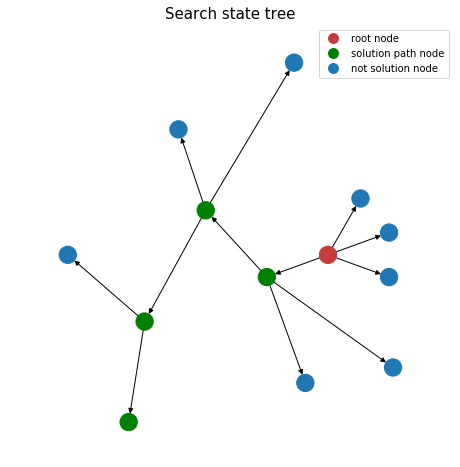

In [42]:
# Draw a graph of the search space for the small example
if draw_branch_and_bound_graph:

    # Plot the graph directly in the jupyter notebook
    %matplotlib inline
    
    # This line finds the positions of the nodes in the graph
    pos = graphviz_layout(H, prog='twopi')
    fig = plt.figure(figsize=(8, 8))
    
    plt.title("Search state tree", fontsize=15)
    
    # Put together the legend.
    colors = ['#c63b3b', '#008000', '#1f78b4']
    dots = [Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor=c, markersize=12) for c in colors]
    labels = ['root node', 'solution path node', 'not solution node']
    plt.legend(dots, labels)
    
    # Draw the actual graph.
    # Equal axis is necessary for the circular apperance.
    nx.draw(H, pos, node_size=300, node_color=color_list, with_labels=False)
    plt.axis('equal')
    plt.show()

If you do not run the graph drawing yourself, you can see the result here anyway. It should look like below.
One can see, that for this small 5x5 matrix, there are 4 possible destinations after the starting city. This options are represented by the 4 nodes closest to the red root node. However, the algorithm only needs to explore more deeply one of these four alternatives, because after the reduction on the first level the estimated cost for the three other nodes are already higher than the found solution. The solution can be seen as the green path.

![state_space_graph_test.png](img/state_space_graph_test.png)

In [30]:
# Run the algorithm on the real msg data
nodes_queue_real, G, N = initialize_for_given_adjaceny_matrix(adjacency_matrix)
minimum_solution_node, G = branch_and_bound(nodes_queue_real, G, N)

A minimal solution was found with a length of 2989.2 km.
The search has ended!
In total 12447 nodes got explored during the execution.
At the end there were still 134379 nodes in the queue, that got effectively cut by Branch-and-Bound.
Execution time : 18.34 seconds


So, the algorithm came to a result. It was really efficient in terms of execution.
On my laptop (Intel i7, 16 GB RAM) it takes far less than a minute to find the optimal solution.

Let's see how the content of the solution node looks like:

In [31]:
G.nodes[minimum_solution_node]

{'node_id': 146783,
 'current_city': 11,
 'tour': [0,
  16,
  4,
  8,
  1,
  2,
  10,
  9,
  17,
  13,
  14,
  6,
  5,
  12,
  7,
  20,
  3,
  18,
  19,
  15,
  11,
  0],
 'level': 20,
 'reduced_matrix': array([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf,

The matrix is completly processed, all entries are infinity except for the last trip back to the starting location.
The following tour is the order of the cities.

In [32]:
solution_tour = G.nodes[minimum_solution_node]['tour']
solution_tour

[0, 16, 4, 8, 1, 2, 10, 9, 17, 13, 14, 6, 5, 12, 7, 20, 3, 18, 19, 15, 11, 0]

----------------------------------------------------------

## 4. The Result

So, the solution path is found, let's have a look on what it means in this last section. The function `summarize_the_result` pretty prints the results by interpreting the numbers as cities as well as setting up a summarizing data frame. The function `sec_to_pretty_time` helps with printing the durations.

In [33]:
# Import the dataframe with the durations between the cities.
duration_df = pd.read_csv('duration_matrix.csv', index_col = 0)
duration_matrix = duration_df.values

In [34]:
# The durations are stored in seconds.
# This function helps to pretty print it
def sec_to_pretty_time(seconds):
    days = int(np.floor(seconds / (60 * 60 * 24)))
    seconds_after_days = seconds % (60 * 60 * 24)
    
    hours = int(np.floor(seconds_after_days / (60 * 60)))
    seconds_after_hours = seconds_after_days % (60 * 60)
    
    minutes = int(np.floor(seconds_after_hours / 60))
    seconds_after_minutes = int(seconds_after_hours % 60)
    if days > 0:
        string = f"{days:02} d, {hours:02} h, {minutes:02} m, {seconds_after_minutes:02} s"
    else:
        string = f"{hours:02} h, {minutes:02} m, {seconds_after_minutes:02} s"
    
    return string

In [35]:
# City list is the ordered solution, the matrices are needed to assign values to the trips
def summarize_the_result(city_list, adjacency_matrix, duration_matrix):
    
    # Initalize strings and a new data frame
    simple_string = ""
    pretty_string = ""
    result_df = pd.DataFrame(columns=['start', 'destination', 'distance in km', 'duration in sec', 'duration'])
    
    # Parsing through the solution list and appending the pretty string as well as the data frame
    for i in range(len(city_list) - 1):
        start = cities.loc[city_list[i]]["msg Standort"]
        destination = cities.loc[city_list[i + 1]]["msg Standort"]
        distance = adjacency_matrix[city_list[i]][city_list[i+1]]
        duration_in_sec = duration_matrix[city_list[i]][city_list[i+1]]
        duration = sec_to_pretty_time(duration_in_sec)
        
        simple_string = simple_string + start +', '
        
        
        pretty_string += start
        pretty_string += "  ➡️ {0} km 🚴‍♂️ ➡️  ".format(distance)
        
        # Appending a row to the data frame
        result_df = result_df.append({'start': start,
                                      'destination': destination,
                                      'distance in km': distance,
                                      'duration in sec': duration_in_sec,
                                      'duration': duration,
                                     }, ignore_index=True)                     
    
    simple_string += cities.loc[0]["msg Standort"]
    pretty_string += cities.loc[0]["msg Standort"]    
    
    return result_df, pretty_string, simple_string

In [36]:
result_df, pretty_string, simple_string = summarize_the_result(solution_tour, adjacency_matrix, duration_matrix)
print(pretty_string)

Ismaning/München (Hauptsitz)  ➡️ 164.9 km 🚴‍♂️ ➡️  Passau  ➡️ 391.4 km 🚴‍♂️ ➡️  Chemnitz  ➡️ 178.5 km 🚴‍♂️ ➡️  Görlitz  ➡️ 237.8 km 🚴‍♂️ ➡️  Berlin  ➡️ 238.8 km 🚴‍♂️ ➡️  Braunschweig  ➡️ 62.3 km 🚴‍♂️ ➡️  Hannover  ➡️ 158.6 km 🚴‍♂️ ➡️  Hamburg  ➡️ 175.9 km 🚴‍♂️ ➡️  Schortens/Wilhelmshaven  ➡️ 141.9 km 🚴‍♂️ ➡️  Lingen (Ems)  ➡️ 72.3 km 🚴‍♂️ ➡️  Münster  ➡️ 83.7 km 🚴‍♂️ ➡️  Essen  ➡️ 35.5 km 🚴‍♂️ ➡️  Düsseldorf  ➡️ 53.0 km 🚴‍♂️ ➡️  Köln/Hürth  ➡️ 220.4 km 🚴‍♂️ ➡️  Frankfurt  ➡️ 111.0 km 🚴‍♂️ ➡️  Walldorf  ➡️ 39.4 km 🚴‍♂️ ➡️  Bretten  ➡️ 140.3 km 🚴‍♂️ ➡️  St. Georgen  ➡️ 109.6 km 🚴‍♂️ ➡️  Stuttgart  ➡️ 204.5 km 🚴‍♂️ ➡️  Nürnberg  ➡️ 92.3 km 🚴‍♂️ ➡️  Ingolstadt  ➡️ 77.1 km 🚴‍♂️ ➡️  Ismaning/München (Hauptsitz)


In [37]:
simple_string

'Ismaning/München (Hauptsitz), Passau, Chemnitz, Görlitz, Berlin, Braunschweig, Hannover, Hamburg, Schortens/Wilhelmshaven, Lingen (Ems), Münster, Essen, Düsseldorf, Köln/Hürth, Frankfurt, Walldorf, Bretten, St. Georgen, Stuttgart, Nürnberg, Ingolstadt, Ismaning/München (Hauptsitz)'

So, above is the order of the journey! Important side note: Because I took the assumption of symmetric distances, the route could also be done in the exact opposite order, so from Ismaning to Ingolstadt, to Nürnberg, and so on until Passau and then Ismaning.

And the table below summarizes the steps.

In [38]:
result_df

,start,destination,distance in km,duration in sec,duration
0,Ismaning/München (Hauptsitz),Passau,164.9,30550,"08 h, 29 m, 10 s"
1,Passau,Chemnitz,391.4,81528,"22 h, 38 m, 48 s"
2,Chemnitz,Görlitz,178.5,36885,"10 h, 14 m, 45 s"
3,Görlitz,Berlin,237.8,45350,"12 h, 35 m, 50 s"
4,Berlin,Braunschweig,238.8,44283,"12 h, 18 m, 03 s"
5,Braunschweig,Hannover,62.3,11706,"03 h, 15 m, 06 s"
6,Hannover,Hamburg,158.6,29452,"08 h, 10 m, 52 s"
7,Hamburg,Schortens/Wilhelmshaven,175.9,32747,"09 h, 05 m, 47 s"
8,Schortens/Wilhelmshaven,Lingen (Ems),141.9,26085,"07 h, 14 m, 45 s"
9,Lingen (Ems),Münster,72.3,13640,"03 h, 47 m, 20 s"


Let's have a look at some details.

In [39]:
max_row = result_df[result_df["distance in km"] == np.max(result_df["distance in km"])]
print(f"The longest part is the trip from {max_row.start.values[0]} to {max_row.destination.values[0]} and takes {max_row.duration.values[0]} for {max_row['distance in km'].values[0]} km.")
      
min_row = result_df[result_df["distance in km"] == np.min(result_df["distance in km"])]
print(f"The shortest part is the trip from {min_row.start.values[0]} to {min_row.destination.values[0]} and takes {min_row.duration.values[0]} for {min_row['distance in km'].values[0]} km.")

The longest part is the trip from Passau to Chemnitz and takes 22 h, 38 m, 48 s for 391.4 km.
The shortest part is the trip from Essen to Düsseldorf and takes 01 h, 57 m, 28 s for 35.5 km.


And of course the overall sum of distance and duration:

In [40]:
sum_of_km = np.round(np.sum(result_df['distance in km']), decimals=1)
sum_of_seconds = np.sum(result_df['duration in sec'])

print(f"The entire trip has a length of {sum_of_km} km.")
print(f"The entire trip will take {sum_of_seconds} seconds on a bike according to Google Maps.")
print(f"To read it more nicely, the seconds are equal to a duration of {sec_to_pretty_time(sum_of_seconds)}.")      

The entire trip has a length of 2989.2 km.
The entire trip will take 583301 seconds on a bike according to Google Maps.
To read it more nicely, the seconds are equal to a duration of 06 d, 18 h, 01 m, 41 s.


So, after almost **3.000 km and almost a week of pure cycling time**, my shortest bike trip to all 21 msg locations would come to an end.

I noticed one fact regarding the exact length: Because I extract the distances from Google Maps, the shortest distance can vary a bit due to time of day, traffic, etc. The difference is only minor. The order of cities stays the same. 

With the webtool https://www.morethan10.com/ I was able to concatenate the 21 trips in Google Maps for bikes. The result on a map looks as shown below. The solution appears to be optimal and the concatenated distance is equal to the distance that the algorithm calculated.

![Result route](img/Result_route.png)

If you arrived at this place: Thank you for reading so far!

I had a lot of fun putting this together. I hope you had a little bit of entertainment along the way, too.